First test the sqw stuff on something I know I'll understand, a spherical wave.

The wave will have the following functional form:
$$ f(r,t) = \sin(k_0 r + \omega_0 t) $$

The Fourier transform of isa delta function in frequency, $\delta(\omega-\omega_0)$, but in space it's a bit harder. I thought it would just be a delta function in space, $\delta(|\vec{k}| - k_0)$, but it turns out to involve an integral over a Bessel Function of the first kind. Specifically:

$$ \int\limits_0^{\infty} \; dr \; r J_0(kr) e^{ik_0 r} $$

So we don't really get zero signal in the $\omega$ direction.

In [1]:
import matplotlib.pyplot as plt
%matplotlib notebook

import numpy as np
import scipy.integrate as integrate
import dynamicstructurefactor.sqw as sqw
import os

In [2]:
savestuff = False
savepath = '/media/daniel/storage1/Dropbox/LLM_Danny/excitableMembranes/sphericalWaveTest/'

# Set up parameters
xmax = 6*np.pi  # total distance in physical units
ymax = 6*np.pi
tmax = 100
nx = 250  # total number of pixels across
ny = 250
nt = 100
dx = xmax / nx  # sampling spacing
dy = ymax / ny
dt = tmax / nt 

xArr = np.linspace(-xmax/2, xmax/2, nx)
yArr = np.linspace(-ymax/2, ymax/2, ny)
tArr = np.linspace(0, tmax, nt)

# Set up grid in real space, remembering to multiply by the 
# sampling periods in time and space
tt,xx,yy = np.meshgrid(tArr, xArr, yArr, indexing='ij')

# Spatial and temporal frequency (in radians/length or time)
lambda0 = np.pi
k0 = 2*np.pi / lambda0
T0 = 10
w0 = 2*np.pi / T0
lambda1 = 0.2 * np.pi
k1 = 2*np.pi / lambda1
T1 = 4
w1 = 2*np.pi / T1

# Center offset
x0 = 50 * dx
y0 = -15 * dy
x1 = 100 * dx
y1 = 83 * dy

Enter the functional form to analyze and get it's power spectrum

In [3]:
# Function and its power spectrum
r0 = ((xx-x0)**2 + (yy-y0)**2)**0.5
r1 = ((xx-x1)**2 + (yy-y1)**2)**0.5
rt = np.sin(k0*r0 - w0*tt) + np.sin(k1*r1 + w1*tt)
qwPower, [ww, qx, qy] = sqw.psdn(rt, 
                                 fs=1/np.array([dt, dx, dy]),
                                 window='hanning',
                                 return_onesided=False,
                                 scaling='density')

Plot the resulting power spectrum in both the real and fourier domain

<IPython.core.display.Javascript object>


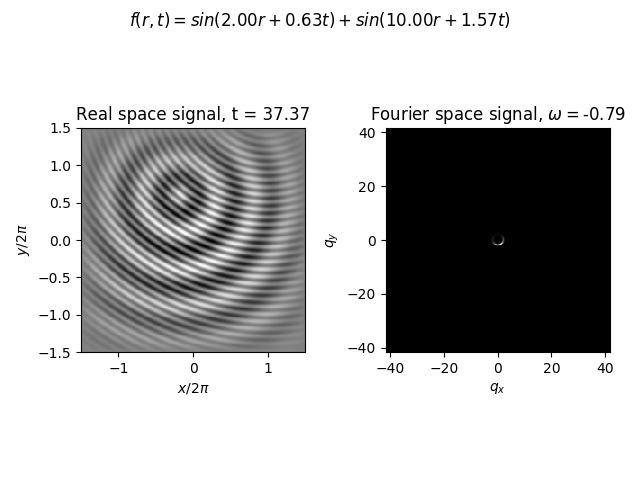

In [4]:
fig,ax = plt.subplots(1,2)
frame = 37

# Get an idea of what this looks like. There's a .gif of the full animation in this folder
ax[0].pcolor(xArr / (2 * np.pi), yArr / (2 * np.pi), rt[frame, :, :], cmap= 'gray')
ax[0].set_aspect('equal')
ax[0].set_xlabel(r'$x/2\pi$')
ax[0].set_ylabel(r'$y/2\pi$')
ax[0].set_title('Real space signal, t = {time:0.2f}'.format(time = tArr[frame]))

ax[1].pcolor(qx, qy, qwPower[frame, :, :], cmap = 'gray')
ax[1].set_aspect('equal')
ax[1].set_xlabel('$q_x$')
ax[1].set_ylabel('$q_y$')
ax[1].set_title('Fourier space signal, $\omega =${w:0.2f}'.format(w=ww[frame]))

fig.suptitle(r'$f(r,t) = sin ({k:0.2f}r + {w:0.2f}t) + sin ({k2:0.2f}r + {w2:0.2f}t)$'.format(k=k0, w=w0, k2=k1, w2=w1))
plt.tight_layout()

if savestuff:
    if not os.path.exists(os.path.join(savepath, 'frames_2waves')): os.mkdir(os.path.join(savepath, 'frames_2waves'))
    for ii in range(0,nt):
        fig,ax = plt.subplots(1,2)

        ax[0].pcolor(xArr / (2 * np.pi), yArr / (2 * np.pi), rt[ii, :,:], cmap='gray')
        ax[0].set_aspect('equal')
        ax[0].set_xlabel(r'$x/2\pi$')
        ax[0].set_ylabel(r'$y/2\pi$')
        ax[0].set_title('Real space signal, t = {time:0.2f}'.format(time = tArr[ii]))

        ax[1].pcolor(qx, qy, qwPower[ii, :, :], cmap = 'gray')
        ax[1].set_aspect('equal')
        ax[1].set_xlabel('$q_x$')
        ax[1].set_ylabel('$q_y$')
        ax[1].set_title('Fourier space signal, $\omega =${w:0.2f}'.format(w=ww[ii]))

        fig.suptitle('f(r,t) = sin ({k:0.2f}r + {w:0.2f}t)'.format(k=k0, w=w0))
        plt.tight_layout()
        
        fig.savefig(os.path.join(savepath,'frames_2waves','frame_'+str(ii)+'.png'),format='png')
        plt.close(fig)

Now get the azimuthally averaged power, and the radial coordinate 

In [5]:
qwPowerRadialAvg, qr = sqw.azimuthal_average_3D(qwPower,
                                                tdim=0,
                                                center=None,
                                                binsize=1.0,
                                                mask=None,
                                                weight=None,
                                                dx=np.diff(qx)[0])

<IPython.core.display.Javascript object>


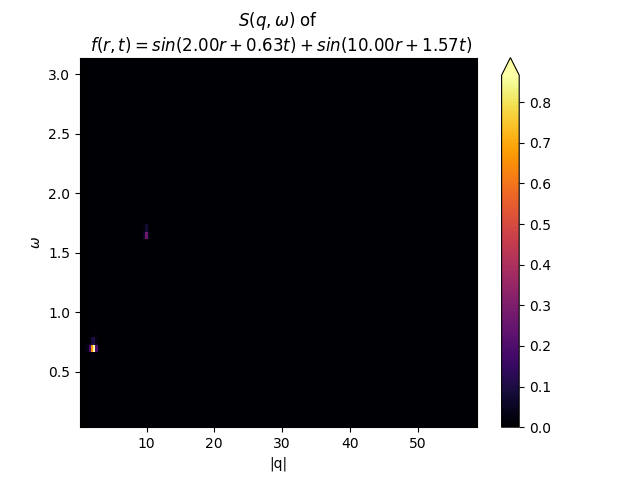

/home/daniel/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [6]:
# qxOneSided = np.fft.ifftshift(qx)[:int(np.floor(qx.size/2))]
wwOneSided = np.fft.ifftshift(ww)[:int(np.floor(ww.size/2))]

fig2, ax2 = plt.subplots()
oneSidedPower = qwPowerRadialAvg[(nt / 2):-1, :]

sphericalSQW = ax2.pcolor(qr,wwOneSided,
                          oneSidedPower,
                          cmap='inferno')
ax2.set_xlabel('|q|')
ax2.set_ylabel('$\omega$')
ax2.set_title('$S(q,\omega)$ of \n $f(r,t) = sin ({k:0.2f}r + {w:0.2f}t) + sin ({k2:0.2f}r + {w2:0.2f}t)$'.format(k=k0, w=w0, k2=k1, w2=w1))

cbar = fig2.colorbar(sphericalSQW, extend='max')

if savestuff:
    fig2.savefig('sqw_sphericalWave.tif',format='tif')
    fig2.savefig('sqw_sphericalWave.eps',format='eps')
#     fig2.savefig('sqw_offset.tif',format='tif')
#     fig2.savefig('sqw_offset.eps',format='eps')

Okay, overall seems good. I'm a little unclear as to why the spatial component is smeared out a bit...

Update 7/11/2017: It's smeared out due to edge/corner effects, where the signal can't be described by a pure sine wave.

The single peak really gives the wave speeds here too, using a linear dispersion relation: $\omega = v q$

Normalize by $S(q)$ and look at $S(q,\omega)/S(q)$ to show it removes the signal along $q$

<IPython.core.display.Javascript object>


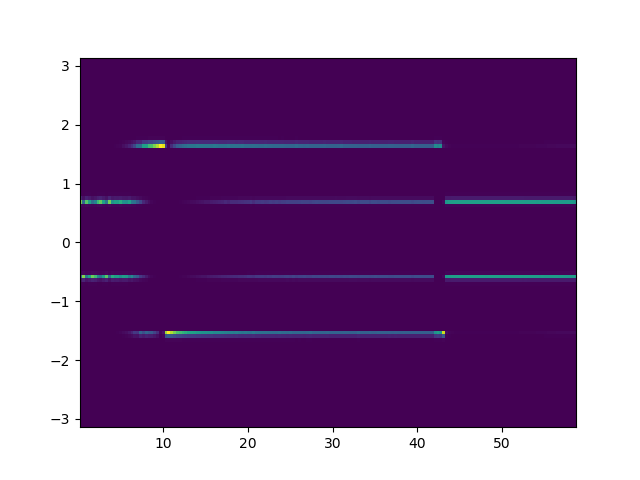

In [7]:
sofcue = integrate.trapz(qwPowerRadialAvg, ww, axis=0)

normed = qwPowerRadialAvg/sofcue[:,None].T

fig, ax = plt.subplots()
ax.pcolor(qr, ww, normed)


In [8]:
qwPowerRadialAvg.shape

(100, 176)